In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('dataset/train.csv')

In [3]:
df['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [4]:
# create a function that will extract all the unique words from the dataset
def unique_words(df):
    unique_words = []
    for i in range(len(df)):
        for word in df['text'][i].split():
            if word not in unique_words:
                unique_words.append(word)
    return unique_words


In [5]:
arr = unique_words(df)

In [ ]:
len(arr)

31924

In [ ]:
# create a function that will create a dictionary of all the unique words and their frequency in the dataset
def word_freq(df):
    unique_words = []
    for i in range(len(df)):
        for word in df['text'][i].split():
            if word not in unique_words:
                unique_words.append(word)
    word_freq = {}
    for word in unique_words:
        word_freq[word] = 0
    for i in range(len(df)):
        for word in df['text'][i].split():
            word_freq[word] += 1
    return word_freq

In [ ]:
word_dict = word_freq(df)

In [ ]:
# do tokenization of all the words present in the dictionary
def tokenize_words(dictionary):
    tokens = {}
    ind = 0
    for word in dictionary:
        tokens[word] = ind
        ind += 1
    return tokens

In [ ]:
tokens = tokenize_words(word_dict)

In [ ]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

d:\Anaconda\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import pandas as pd
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
submission = pd.read_csv('dataset/sample_submission.csv')

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# create a dictionary which has id as keys and text as values
def create_dict(df):
    dict = {}
    for i in range(len(df)):
        dict[df['id'][i]] = df['text'][i]
    return dict

In [ ]:
dict = create_dict(train)
#print(dict)

In [ ]:
train.drop(['id','keyword', 'location'], axis=1, inplace=True)
test.drop(['id', 'keyword', 'location'], axis=1, inplace=True)

In [ ]:
# how to find number of zeroes and ones in the target column
def count_zeroes_ones(target):
    zeroes = 0
    ones = 0
    for i in range(len(target)):
        if target[i] == 0:
            zeroes += 1
        else:
            ones += 1
    return zeroes, ones

In [ ]:
zeroes, ones = count_zeroes_ones(train['target'])

<BarContainer object of 2 artists>

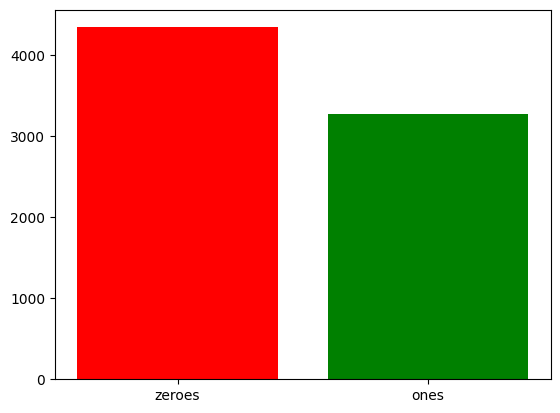

In [ ]:
#plot a bar graph to show the distribution of the target column
import matplotlib.pyplot as plt
# change color of the bars
plt.bar(['zeroes', 'ones'], [zeroes, ones], color=['red', 'green'])


In [ ]:
lablels = train['target'].tolist()
tweets = train['text'].tolist()

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
inputs = tokenizer(tweets, padding="max_length", truncation=True)

In [ ]:
import torch

class twitterdataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
train_dataset = twitterdataset(inputs, lablels)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

d:\Anaconda\envs\myenv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aditya Singh\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.trans

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    num_train_epochs=3,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    # eval_dataset=test_dataset          # evaluation dataset
    # compute_metrics=compute_metrics    # define metrics function
)

trainer.train()

d:\Anaconda\envs\myenv\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  1%|          | 10/1428 [19:58<47:44:32, 121.21s/it]

{'loss': 0.7737, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.02}


  1%|▏         | 20/1428 [31:56<21:30:10, 54.98s/it] 

{'loss': 0.6893, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.04}


  2%|▏         | 30/1428 [2:59:22<59:27:15, 153.10s/it]  

{'loss': 0.6924, 'learning_rate': 3e-06, 'epoch': 0.06}


  3%|▎         | 40/1428 [3:07:41<19:56:05, 51.70s/it] 

{'loss': 0.6522, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.08}


  4%|▎         | 50/1428 [3:16:33<19:40:40, 51.41s/it]

{'loss': 0.6689, 'learning_rate': 5e-06, 'epoch': 0.11}


  4%|▍         | 60/1428 [3:55:24<226:51:50, 597.01s/it]

{'loss': 0.5798, 'learning_rate': 6e-06, 'epoch': 0.13}


  5%|▍         | 70/1428 [4:03:46<25:08:19, 66.64s/it]  

{'loss': 0.5964, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.15}


  6%|▌         | 80/1428 [4:11:48<17:59:50, 48.06s/it]

{'loss': 0.5831, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.17}


  6%|▋         | 90/1428 [5:21:03<143:32:34, 386.21s/it]

{'loss': 0.4735, 'learning_rate': 9e-06, 'epoch': 0.19}


  7%|▋         | 100/1428 [5:43:44<28:45:16, 77.95s/it] 

{'loss': 0.5546, 'learning_rate': 1e-05, 'epoch': 0.21}


  7%|▋         | 106/1428 [6:58:05<478:44:44, 1303.69s/it]

KeyboardInterrupt: 